In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer 
import pickle 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Dropout
from tensorflow.keras import losses
from keras.models import load_model
from flask import Flask, request, jsonify, render_template
from src.helper import pre_process

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv("Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [4]:
len(df.index)

16298

In [5]:
print(df.isnull().sum())
df = df.dropna()

clean_text    4
category      7
dtype: int64


In [6]:
print(df.isnull().sum())

clean_text    0
category      0
dtype: int64


In [7]:
len(df.index)

16295

In [7]:
all_pos = df[df['category']==1]['clean_text']
all_neg = df[df['category']==-1]['clean_text']
all_neu = df[df['category']==0]['clean_text']

In [9]:
all_pos

0        writing she the only leader standing for usual...
1        yes that’ what the country wants let’ see how ...
3        free wifi for development internet opens wide ...
5        assumption right sir rahul will contest from a...
8        modi will proud this and still saying give one...
                               ...                        
16283                 did shatru have votes was modi magic
16291    both are irrelevant for would rather focus job...
16292    smart money positioning itself for the governm...
16293    next time while talking about job opportunitie...
16297    the problem except for rare few like modi nobo...
Name: clean_text, Length: 7167, dtype: object

In [10]:
tot_pos_words = []
for tweet in all_pos:
    tot_pos_words.append(tweet.count(' '))

tot_neg_words = []
for tweet in all_neg:
    tot_neg_words.append(tweet.count(' '))

tot_neu_words = []
for tweet in all_neu:
    tot_neu_words.append(tweet.count(' '))

In [11]:
tot_pos_words[:20]

[33,
 27,
 38,
 35,
 14,
 11,
 33,
 17,
 29,
 31,
 22,
 19,
 26,
 33,
 15,
 12,
 30,
 13,
 36,
 12]

<Axes: ylabel='Count'>

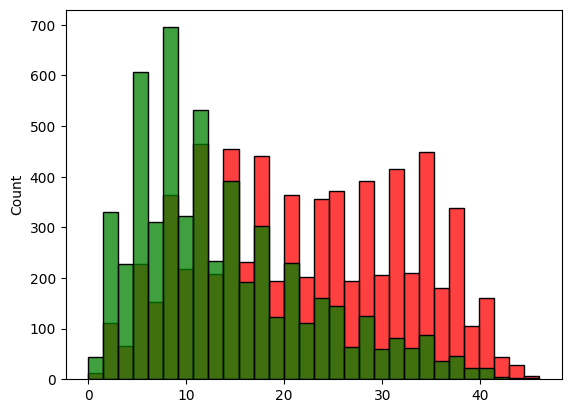

In [12]:
sns.histplot(tot_pos_words,bins=30,color='r')
# sns.histplot(tot_neg_words,bins=30,color='b)
sns.histplot(tot_neu_words,bins=30,color='g')

In [13]:
df['category'].value_counts()

category
 1.0    7167
 0.0    5572
-1.0    3556
Name: count, dtype: int64

In [14]:
category_count = [cnt for cnt in df['category'].value_counts()]
category_count

[7167, 5572, 3556]

<Axes: >

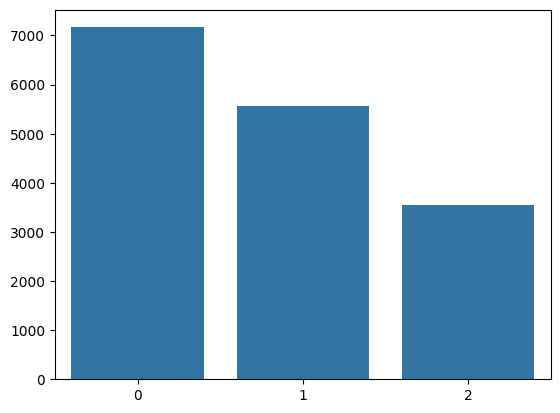

In [15]:
sns.barplot(category_count)
# Pos:1 | Neu:0 | Neg:-1

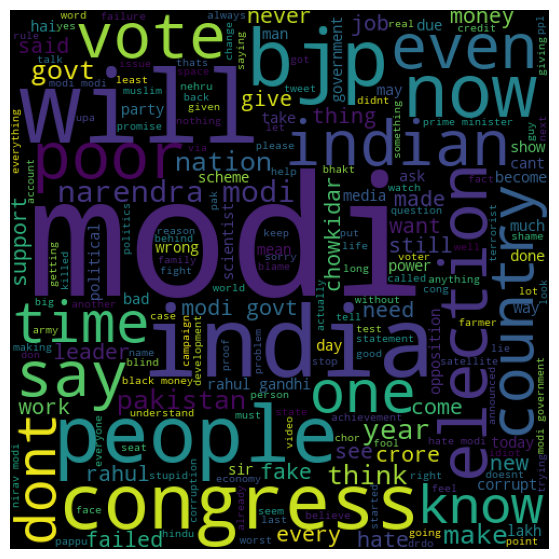

In [16]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
positive_wc = wc.generate(df[df['category'] == 1.0]['clean_text'].str.cat(sep = " "))
neutral_wc = wc.generate(df[df['category'] == 0.0]['clean_text'].str.cat(sep = " "))
negative_wc = wc.generate(df[df['category'] == -1.0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (10, 7))
plt.axis('off')
plt.imshow(positive_wc)

(-0.5, 499.5, 499.5, -0.5)

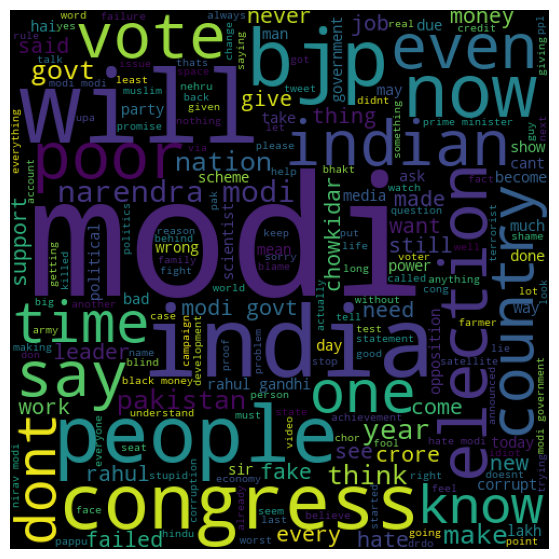

In [17]:
plt.figure(figsize = (10, 7))
plt.imshow(negative_wc)
plt.axis('off')

### Removing stopwords

In [8]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [10]:
stopword = stopwords.words('english')
print(stopword)
print(string.punctuation)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [11]:
# Removing stopwords
df['clean_text'] = df['clean_text'].apply(lambda x:' '.join([word for word in x.split() if word not in (stopword)]))

In [12]:
df['clean_text'][:4]

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
Name: clean_text, dtype: object

In [24]:
type(string.punctuation)

str

In [13]:
import re
# Removing punctuation
# re.sub(pattern, repl, string) | not (words and space)
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [26]:
df['clean_text'][:4]

0    writing leader standing usually watch phone ne...
1    yes that country wants let see long start atta...
2           cause modi didnt promise payment nithallas
3    free wifi development internet opens wide rang...
Name: clean_text, dtype: object

In [14]:
# Use porter stemmer
stemmer = PorterStemmer()
def stemming(sentence):
    lis = []
    for word in sentence.split():
        lis.append(stemmer.stem(word))
    return ' '.join(lis)

df['clean_text'] = df['clean_text'].apply(lambda x:stemming(x))        

In [15]:
df['category'] = [2 if x==-1 else x for x in df['category']]

In [16]:
df2 = df.copy() # Save a copy 

In [30]:
df.head()

,clean_text,category
0,write leader stand usual watch phone new updat...,1.0
1,ye that countri want let see long start attack...,1.0
2,caus modi didnt promis payment nithalla,0.0
3,free wifi develop internet open wide rang know...,1.0
4,modi govt ban counterfeit currenc transparency...,2.0


In [1]:
import tensorflow as tf
print(tf.__version__)

from keras import __version__
print(__version__)



2.15.0
2.15.0


In [17]:
# Tokenize the words
from tensorflow.keras.preprocessing.text import Tokenizer 

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])

In [19]:
word_index = tokenizer.word_index
word_index

{'modi': 1,
 'india': 2,
 'bjp': 3,
 'peopl': 4,
 'like': 5,
 'congress': 6,
 'elect': 7,
 'vote': 8,
 'narendra': 9,
 'say': 10,
 'nation': 11,
 'govt': 12,
 'one': 13,
 'indian': 14,
 'year': 15,
 'time': 16,
 'countri': 17,
 'dont': 18,
 'give': 19,
 'want': 20,
 'get': 21,
 'know': 22,
 'rahul': 23,
 'make': 24,
 'support': 25,
 'govern': 26,
 'even': 27,
 'take': 28,
 'also': 29,
 'come': 30,
 'power': 31,
 'work': 32,
 'parti': 33,
 'gandhi': 34,
 'minist': 35,
 'polit': 36,
 'think': 37,
 'need': 38,
 'credit': 39,
 'leader': 40,
 'see': 41,
 'good': 42,
 'ask': 43,
 'space': 44,
 'would': 45,
 'money': 46,
 'said': 47,
 'hai': 48,
 'win': 49,
 'pakistan': 50,
 'done': 51,
 'chowkidar': 52,
 'sir': 53,
 'promis': 54,
 'back': 55,
 'job': 56,
 'prime': 57,
 'everi': 58,
 'day': 59,
 'opposit': 60,
 'announc': 61,
 'scientist': 62,
 'via': 63,
 'today': 64,
 'achiev': 65,
 'never': 66,
 '2019': 67,
 'use': 68,
 'live': 69,
 'mani': 70,
 'poor': 71,
 'call': 72,
 'world': 73,
 'new

In [20]:
import pickle 
# Saving
with open('token_new.pickle','wb') as handle: #write-binary mode
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # To use latest version

# Loading
with open('token_new.pickle','rb') as handle:
    tokenizer = pickle.load(handle)

In [35]:
vocab_size = len(word_index) + 1

In [36]:
vocab_size

20639

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Padding the tweets
max_length = 200
# Converting text to numbers with padding
lines = pad_sequences(tokenizer.texts_to_sequences(df['clean_text']), maxlen=max_length)
lines

array([[   0,    0,    0, ...,  348,   95,  113],
       [   0,    0,    0, ...,    5,   80,   64],
       [   0,    0,    0, ...,   57, 1993, 8598],
       ...,
       [   0,    0,    0, ..., 1499,  814,   56],
       [   0,    0,    0, ..., 4304,  624,  654],
       [   0,    0,    0, ..., 1556,  115,  452]])

In [38]:
lines.shape

(16295, 200)

In [39]:
df['clean_text'] = lines.tolist()

In [40]:
df.head()

,clean_text,category
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.0


In [57]:
# Split our data 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['clean_text'],df['category'],test_size=0.2,random_state=101)


In [58]:
X_train # List as object

15631    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3261     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4763     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1772     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9833     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
5696     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8008     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1362     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1548     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13153    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: clean_text, Length: 13036, dtype: object

In [59]:
X_train = np.vstack(X_train.values)
y_train = np.vstack(y_train.values)

X_val = np.vstack(X_test.values)
y_val = np.vstack(y_test.values)

In [60]:
y_train

array([[1.],
       [2.],
       [2.],
       ...,
       [2.],
       [2.],
       [1.]])

In [61]:
# Data Modelling

# img

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Dropout
# Sequential Modelling
model = tf.keras.Sequential()

# Input layer # None means Input can have any length
model.add(Input(shape=(None,))) 

# Embedding layer # Converts integers to dense vector of 200 size with padding
model.add(Embedding(input_dim=vocab_size, output_dim=200, trainable=True))

# LSTM Layer
model.add(LSTM(64,activation='relu'))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(3, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 200)      │     4,127,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,199,995 (16.02 MB)

 Trainable params: 4,199,995 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
from tensorflow.keras import losses

model.compile(optimizer='adam', 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

In [64]:
history = model.fit(X_train, y_train,
                    epochs=2, batch_size=512,
                    verbose=1,shuffle=True,validation_data=(X_val,y_val))

Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4986 - loss: 1.0490 - val_accuracy: 0.5594 - val_loss: 0.9284
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6043 - loss: 0.8799 - val_accuracy: 0.6278 - val_loss: 0.8338


In [65]:
# Save model
from keras.models import load_model
model.save("model/lstmmodel.h5")

In [67]:
from keras.models import load_model
# Load the model
lstm_model = load_model("model/lstmmodel.h5")

In [69]:
# Accuracy
predictions = model.predict(X_val)
print(history.history)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step
{'accuracy': [0.5197146534919739, 0.6163700819015503], 'loss': [1.014279842376709, 0.8710127472877502], 'val_accuracy': [0.5593740344047546, 0.627799928188324], 'val_loss': [0.928415834903717, 0.8337749242782593]}


In [70]:
predictions.shape

(3259, 3)

In [71]:
# Evaluation
print("Evaluate on test data")
results = model.evaluate(X_val, y_val, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6242 - loss: 0.8388
test loss, test acc: [0.8337748646736145, 0.627799928188324]


In [1]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [2]:
from keras import __version__
print(__version__)


3.3.3
